# Brain Tumor Detection Using Parallel Processing

## Assignment Overview
In this assignment, you will be tasked with developing a machine learning model for detecting brain tumors from MRI images. You will leverage the power of parallel processing to efficiently handle the large dataset and speed up the computation-intensive tasks involved in image processing and model training.

## Dataset
The dataset consists of MRI images classified into two categories:
- `yes`: Images that contain brain tumors.
- `no`: Images that do not contain brain tumors.

Your goal is to preprocess these images using various filters and techniques, extract relevant features, then train a machine learning model to accurately classify the images as having a tumor or not.

## Parallel Processing
To optimize the performance of your image processing and model training, you are required to implement parallel processing techniques. This could involve using Python's `multiprocessing` and `threading` module to parallelize tasks such as image preprocessing, feature extraction (applying filters), or model training.

## Objectives
1. Load the MRI images using OpenCV.
2. Implement parallel processing to efficiently handle image processing and model training.
3. Train a machine learning model for brain tumor classification.
4. Evaluate the performance of your model on a test set.

## Submission
- Your submission should include the completed Jupyter Notebook with all the code for loading the data, preprocessing, parallel processing implementation, model training, and evaluation. 
- Additionally, provide a brief report discussing your approach, and explaining your code the results obtained.


# Part I: Guided Code (60%)
The following cells in this notebook will demonstrate a sequential example of the brain tumor detection process. This example includes steps such as data loading, pre-processing, feature extraction using methods like GLCM (Gray Level Co-occurrence Matrix) and LBP (Local Binary Patterns), and finally, classification. This sequential process serves as a baseline for what you are expected to parallelize.

## Your Task
After understanding the sequential processing steps, your task is to refactor the code to utilize multiprocessing or multithreading approaches, aiming to reduce the overall processing time. You should focus on parallelizing the most time-consuming tasks identified in the sequential example, such as image processing and feature extraction.

<span style="color: red;">**Remember**: the efficiency of your parallel processing implementation will be evaluated based on the reduction in processing time and the accuracy of your model.</span>

## Data Reading

In this section, we will load the MRI images from the dataset. The dataset consists of two folders: `yes` and `no`, representing images with and without brain tumors, respectively. We will use the `glob` module to list all the image files in these directories and then read them into memory for further processing.

### Creating a reading function

In [11]:
# pip install -r requirements.txt

In [12]:
import glob
import cv2

def read_images(images_path):
    """
    Reads all images from a specified path using OpenCV.

    Parameters:
        - images_path (str): The path to the directory containing the images.
    Returns:
        - images (list): A list of images read from the directory.
    """
    images = []
    for file_path in images_path:
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
                images.append(image)
    return images

### Runing the reading function

In [13]:
# Define the path to the dataset
dataset_path = './data/brain_tumor_dataset/'

# List all image files in the 'yes' and 'no' directories
import re
yes_images = [img for img in glob.glob(dataset_path + 'yes/*') if re.search(r'\.jpg$', img, re.IGNORECASE)]
no_images = [img for img in glob.glob(dataset_path + 'no/*') if re.search(r'\.jpg$', img, re.IGNORECASE)]

# yes_images = glob.glob(dataset_path + 'yes/*.jpg')
# no_images = glob.glob(dataset_path + 'no/*.jpg')

yes_images = read_images(yes_images)
no_images = read_images(no_images)

print(f"Number of 'yes' images: {len(yes_images)}")
print(f"Number of 'no' images: {len(no_images)}")

Number of 'yes' images: 154
Number of 'no' images: 91


## Appyling filters to the images

In this section, we apply various filters to the images to enhance their features. The filters used are:

1. **Entropy Filter**: This filter measures the randomness in the image, highlighting regions with high information content (e.g., edges).

2. **Gaussian Filter**: This filter smooths the image by blurring it, reducing noise and details.

3. **Sobel Filter**: This edge-detection filter highlights the gradients (edges) in the image.

4. **Gabor Filter**: This filter is used for texture analysis, emphasizing edges and texture patterns.

5. **Hessian Filter**: This filter enhances blob-like structures in the image.

6. **Prewitt Filter**: Another edge-detection filter, similar to the Sobel filter, but with a different kernel.

The folowing code is how these filtres are applied to one image (<span style="color: red;">*Your job is to apply them to all images.*</span>).

### Code the applying the filters


In [14]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy import ndimage as nd
from skimage.filters import sobel, gabor, hessian, prewitt
import matplotlib.pyplot as plt

In [33]:
image = yes_images[0]

# Apply filters
entropy_img = entropy(image, disk(2))
gaussian_img = nd.gaussian_filter(image, sigma=1)
sobel_img = sobel(image)
gabor_img = gabor(image, frequency=0.9)[1]
hessian_img = hessian(image, sigmas=range(1, 100, 1))
prewitt_img = prewitt(image)

# Store the original and filtered images in a dictionary
filtered_images = {
    'Original': image,
    'Entropy': entropy_img,
    'Gaussian': gaussian_img,
    'Sobel': sobel_img,
    'Gabor': gabor_img,
    'Hessian': hessian_img,
    'Prewitt': prewitt_img
}

In [31]:
image = yes_images[0]
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy import ndimage as nd
from skimage.filters import sobel, gabor, hessian, prewitt
import numpy as np

from multiprocessing import Pool
from threading import Lock, Thread
from time import time
from tqdm import tqdm

def compute_hessian_for_sigma(args):
    image, sigma = args
    # Note: Passing [sigma] returns an array with an extra dimension: (1, height, width)
    return hessian(image, sigmas=[sigma])  

def compute_hessian(image, sigmas):
    with Pool(processes=None) as pool:
        # Compute a list of arrays, each of shape (1, height, width)
        results = pool.map(compute_hessian_for_sigma, [(image, s) for s in sigmas])
    # Concatenate along axis=0 to form an array of shape (len(sigmas), height, width)
    return np.concatenate(results, axis=0)

def process_single_image(image):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': compute_hessian(image, sigmas=range(1, 100, 1)),  # Parallelized Hessian
        'Prewitt': prewitt(image)
    }
    return filtered_images

filtered_images = process_single_image(image)

### Displaying the results

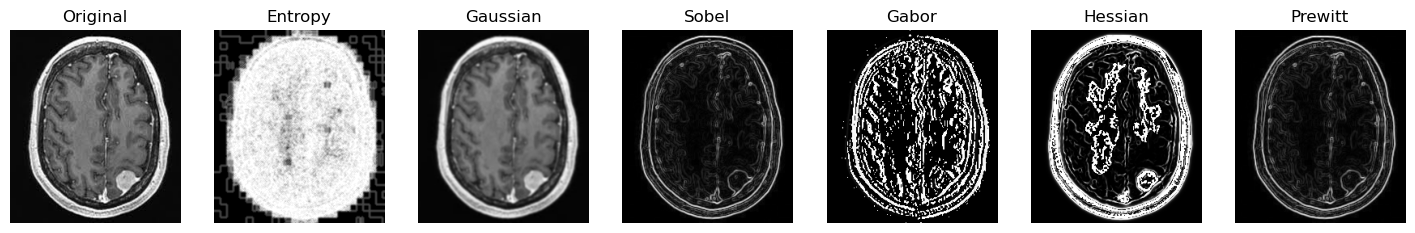

In [34]:
# Display each filtered image
plt.figure(figsize=(18, 3))
for i, (filter_name, filtered_image) in enumerate(filtered_images.items()):
        plt.subplot(1, len(filtered_images), i + 1)
        plt.imshow(filtered_image, cmap='gray')
        plt.title(filter_name)
        plt.axis('off')
plt.show()

TypeError: Invalid shape (211,) for image data

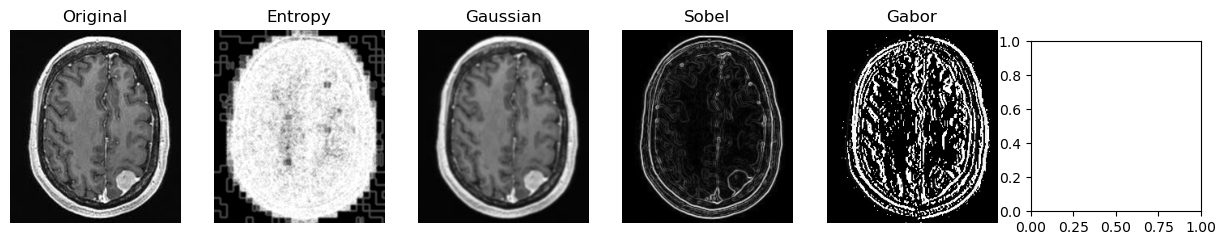

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy import ndimage as nd
from skimage.filters import sobel, gabor, hessian, prewitt
from skimage.color import rgb2gray  # for colour-to-grayscale conversion
from multiprocessing import Pool
from tqdm import tqdm

def compute_hessian_for_sigma(args):
    image, sigma = args
    # Returns shape (1, height, width) when we pass [sigma]
    return hessian(image, sigmas=[sigma])  

def compute_hessian_parallel(image, sigmas):
    """
    Compute multi-scale Hessian in parallel and merge results by taking
    the maximum response across all sigmas, returning a 2D array.
    """
    with Pool(processes=None) as pool:
        # Each item in results is shape (1, H, W)
        results = pool.map(compute_hessian_for_sigma, [(image, s) for s in sigmas])
    # Stack along axis=0 -> shape (len(sigmas), height, width)
    stacked = np.concatenate(results, axis=0)
    # Merge all scales into a single 2D image by taking the maximum across axis=0
    merged = np.max(stacked, axis=0)
    return merged

def process_single_image(image):
    """
    Apply various filters to a single image, including parallel Hessian.
    Returns a dict of the results.
    """
    # 1) Convert colour images to grayscale if needed
    if image.ndim == 3 and image.shape[2] in (3, 4):
        image = rgb2gray(image)  # ensures shape = (height, width)

    # 2) Compute each filter
    entropy_img = entropy(image, disk(2))
    gaussian_img = nd.gaussian_filter(image, sigma=1)
    sobel_img = sobel(image)
    gabor_img = gabor(image, frequency=0.9)[1]
    hessian_img = compute_hessian_parallel(image, sigmas=range(1, 100))
    prewitt_img = prewitt(image)

    # 3) Store all results in a dictionary
    filtered_images = {
        'Original': image,
        'Entropy': entropy_img,
        'Gaussian': gaussian_img,
        'Sobel': sobel_img,
        'Gabor': gabor_img,
        'Hessian': hessian_img,
        'Prewitt': prewitt_img
    }
    return filtered_images

# Example usage:
# Suppose yes_images is a list of images. We take the first one for demonstration.
image = yes_images[0]
filtered_images = process_single_image(image)

# Display each filtered image
plt.figure(figsize=(18, 3))
for i, (filter_name, filtered_image) in enumerate(filtered_images.items()):
    plt.subplot(1, len(filtered_images), i + 1)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(filter_name)
    plt.axis('off')
plt.show()


## <span style="color: blue;">Parallel Image Filtering</span>

In this part of the assignment, you will create a function for each filter and apply them in parallel to the images. You will store the results in dictionaries, similar to the example shown previously. Make sure to handle synchronization appropriately, as multiple threads or processes will access the images.

### <span style="color: green;">Tasks</span>
1. **Sequential execution:**
        1. Loop through the images in both lists: `yes_images` and `no_images` and apply the filters in parallel.
        2. For each image, create a dictionary containing the original and filtered images.
        3. Store these dictionaries in two lists: `yes_inputs` for images with tumors and `no_inputs` for images without tumors.
        4. Time the execution to compute the speed up and the efficiency later.
2. **Parallel execution:**
        1. Create a separate function for each filter and write to be executed in parallel using either multiprocessing or multithreading.
        2. Use a multiprocessing or multithreading (*whatever you wish, from what you have learned in this course*) to manage parallel execution of the filter functions on the images and or the concurrent application on multiple images at the same time.
        3. Implement synchronization mechanisms to ensure safe access to shared resources.
        4. Measure the execution time of the parallel processing to compare it with the sequential execution.
### <span style="color: red;">Warning</span>
- Be cautious about the concurrent access to images by multiple threads or processes. Use appropriate synchronization mechanisms to prevent race conditions and ensure data integrity.
- Carefully choose which parallelization paradigm you will use. *Efficiency* and *Speed* are of utmost importance. You need to see a positive impact on the speedup.
### <span style="color: green;">**Hint:**</span>
When you run you code for testing, run it only one the 4 or 5 first image. Only run on all images in the final version.

In [13]:
## The sequential version

import time
from tqdm import tqdm

def process_images(images):
    processed_images = []
    for image in tqdm(images):
        filtered_images = {
            'Original': image,
            'Entropy': entropy(image, disk(2)),
            'Gaussian': nd.gaussian_filter(image, sigma=1),
            'Sobel': sobel(image),
            'Gabor': gabor(image, frequency=0.9)[1],
            'Hessian': hessian(image, sigmas=range(1, 100, 1)),
            'Prewitt': prewitt(image)
        }
        processed_images.append(filtered_images)
    return processed_images

# Example usage
start_time = time.time()
yes_inputs = process_images(yes_images)
no_inputs = process_images(no_images)
end_time = time.time()

execution_time = end_time - start_time
print(f"Sequential execution time: {execution_time} seconds")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [43:40<00:00, 28.80s/it]

Sequential execution time: 9696.466950178146 seconds


In [13]:
# pooling

import time
from tqdm import tqdm
from multiprocessing import Pool

def process_single_image(image):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': hessian(image, sigmas=range(1, 100, 1)),
        'Prewitt': prewitt(image)
    }
    return filtered_images

def process_images_pooling(images):
    # Use Pool to parallelize the processing
    with Pool() as pool:
        processed_images = list(tqdm(pool.imap(process_single_image, images), total=len(images)))
    return processed_images

# Example usage
start_time = time.time()
yes_inputs_pooling = process_images_pooling(yes_images[0:20])
no_inputs_pooling = process_images_pooling(no_images[0:20])
end_time = time.time()

execution_time_pooling = end_time - start_time
print(f"Pooling execution time: {execution_time_pooling} seconds")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.82s/it]


Pooling execution time: 453.1845848560333 seconds


In [ ]:
# threaded and pooling hessian

import time
from skimage.filters import hessian, sobel, prewitt, gabor
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy import ndimage as nd
from multiprocessing import Pool
import threading
from tqdm import tqdm

def compute_hessian_for_sigma(args):
    image, sigma = args
    return hessian(image, sigmas=[sigma]) 

def compute_hessian(image, sigmas):
    with Pool(processes=None) as pool: 
        results = pool.map(compute_hessian_for_sigma, [(image, s) for s in sigmas])
    return results

def process_single_image(image, output_list, lock):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': compute_hessian(image, sigmas=range(1, 100, 1)),  # Parallelized Hessian
        'Prewitt': prewitt(image)
    }
    
    with lock:  
        output_list.append(filtered_images)

def process_images_threaded(images):
    processed_images = []
    threads = []
    lock = threading.Lock() 

    for image in tqdm(images):
        thread = threading.Thread(target=process_single_image, args=(image, processed_images, lock))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    return processed_images

# Example usage
start_time = time.time()
yes_inputs_threaded = process_images_threaded(yes_images[0:20])
no_inputs_threaded = process_images_threaded(no_images[0:20])
end_time = time.time()

execution_time_threaded = end_time - start_time
print(f"Hessian execution time: {execution_time_threaded:.2f} seconds")



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.68it/s]

Threaded execution time: 247.71 seconds


In [ ]:
# threaded and pooling hessian2

from multiprocessing import Pool
from threading import Lock, Thread
from time import time
from tqdm import tqdm

def compute_hessian_for_sigma(args):
    image, sigma = args
    return hessian(image, sigmas=[sigma]) 

def compute_hessian(image, sigmas):
    with Pool(processes=None) as pool: 
        results = pool.map(compute_hessian_for_sigma, [(image, s) for s in sigmas])
    return results

def process_single_image(image, output_list, lock):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': compute_hessian(image, sigmas=range(1, 100, 1)),  # Parallelized Hessian
        'Prewitt': prewitt(image)
    }
    
    with lock:  
        output_list.append(filtered_images)

def process_images_threaded(images, output_list):
    threads = []
    lock = Lock()  # Ensure thread safety

    for image in tqdm(images):
        thread = Thread(target=process_single_image, args=(image, output_list, lock))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()  # Wait for all threads to complete

def hessian_run(yes_images, no_images):
    start_time = time()

    # Create separate lists for processed images
    yes_processed = []
    no_processed = []

    # Start both sets of images in parallel using threads
    t1 = Thread(target=process_images_threaded, args=(yes_images[0:20], yes_processed))
    t2 = Thread(target=process_images_threaded, args=(no_images[0:20], no_processed))

    t1.start()
    t2.start()

    # Only one join per thread (no need for separate joins for each set)
    t1.join()  # Wait for the `yes_images` thread to finish
    t2.join()  # Wait for the `no_images` thread to finish

    end_time = time()
    execution_time_threaded = end_time - start_time

    print(f"Hessian execution time: {execution_time_threaded:.2f} seconds (combined threading)")
    return execution_time_threaded, yes_processed, no_processed

hessian_run(yes_images[0:20], no_images[0:20])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.40it/s]


Hessian execution time: 376.79 seconds (combined threading)


(376.791184425354,
 [{'Original': array([[9, 9, 9, ..., 8, 8, 8],
          [9, 9, 9, ..., 8, 8, 8],
          [9, 9, 9, ..., 8, 8, 8],
          ...,
          [8, 8, 8, ..., 9, 9, 9],
          [8, 8, 8, ..., 9, 9, 9],
          [8, 8, 8, ..., 9, 9, 9]], dtype=uint8),
   'Entropy': array([[0.        , 0.        , 0.        , ..., 0.91829583, 0.54356444,
           0.        ],
          [0.        , 0.        , 0.        , ..., 0.91829583, 0.43949699,
           0.        ],
          [0.        , 0.        , 0.        , ..., 0.89049164, 0.41381685,
           0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.89049164, 0.41381685,
           0.        ],
          [0.        , 0.        , 0.        , ..., 0.91829583, 0.43949699,
           0.        ],
          [0.        , 0.        , 0.        , ..., 0.91829583, 0.54356444,
           0.        ]]),
   'Gaussian': array([[9, 9, 9, ..., 8, 8, 8],
          [9, 9, 9, ..., 8, 8, 8],
          [9, 9, 9,

: 

In [ ]:
## The multiprocesses version

import time
from tqdm import tqdm
from multiprocessing import Manager, Process
import numpy as np

def process_single_image(image, processed_images):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': hessian(image, sigmas=range(1, 100, 1)),
        'Prewitt': prewitt(image)
    }
    processed_images.append(filtered_images)

def process_images_multiprocesses(images):
    manager = Manager()
    processed_images = manager.list()
    processes = []
    
    for image in tqdm(images):
        # Create a new process for each image
        process = Process(target=process_single_image, args=(image, processed_images))
        processes.append(process)
        process.start()

    # Ensure all processes complete
    for process in processes:
        process.join()

    return list(processed_images)

# Example usage
start_time = time.time()
yes_inputs_multiprocesses = process_images_multiprocesses(yes_images)
no_inputs_multiprocesses = process_images_multiprocesses(no_images)
end_time = time.time()

execution_time_multiprocesses = end_time - start_time
print(f"Processes execution time: {execution_time_multiprocesses} seconds")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:38<00:00,  2.36it/s]


Parallel execution time: 1898.715719461441 seconds


In [ ]:
#threaded

import time
from tqdm import tqdm
import threading

def process_single_image(image, processed_images):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': hessian(image, sigmas=range(1, 100, 1)),
        'Prewitt': prewitt(image)
    }
    processed_images.append(filtered_images)

def process_images_threaded(images):
    processed_images = []
    threads = []
    
    for image in tqdm(images):
        # Create a new thread for each image
        thread = threading.Thread(target=process_single_image, args=(image, processed_images))
        threads.append(thread)
        thread.start()

    # Ensure all threads complete
    for thread in threads:
        thread.join()

    return processed_images

# Example usage
start_time = time.time()
yes_inputs_threaded = process_images_threaded(yes_images[0:6])
no_inputs_threaded = process_images_threaded(no_images[0:6])
end_time = time.time()

execution_time_threaded = end_time - start_time
print(f"Threaded execution time: {execution_time_threaded} seconds")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1950.39it/s]


Threaded execution time: 90.40717554092407 seconds


In [ ]:
# intial combined attempt 

import time
from tqdm import tqdm
import threading
from multiprocessing import Manager, Process

# Function to load images using threading
def load_image(image_path, image_list):
    image_list.append(image_path)

# Function to process images (parallel version using Process)
def process_single_image(image, processed_images):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': hessian(image, sigmas=range(1, 100, 1)),
        'Prewitt': prewitt(image)
    }
    processed_images.append(filtered_images)

# Function to process images using multiprocessing (parallel)
def process_images_parallel(images):
    manager = Manager()
    processed_images = manager.list()
    processes = []

    for image in tqdm(images):
        # Create a new process for each image
        process = Process(target=process_single_image, args=(image, processed_images))
        processes.append(process)
        process.start()

    # Ensure all processes complete
    for process in processes:
        process.join()

    return list(processed_images)

# Function to load images using threading
def load_images_threaded(images_path):
    threads = []
    loaded_images = []

    for image_path in images_path:
        thread = threading.Thread(target=load_image, args=(image_path, loaded_images))
        threads.append(thread)
        thread.start()

    # Ensure all threads complete
    for thread in threads:
        thread.join()

    return loaded_images

# Example usage
start_time = time.time()

# Threaded image loading
yes_images_loaded = load_images_threaded(yes_images)
no_images_loaded = load_images_threaded(no_images)

# Parallel image processing
yes_inputs_parallel = process_images_parallel(yes_images_loaded)
no_inputs_parallel = process_images_parallel(no_images_loaded)

end_time = time.time()

execution_time_combined = end_time - start_time
print(f"Combined threading and parallel execution time: {execution_time_combined} seconds")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:19<00:00,  4.60it/s]


Combined threading and parallel execution time: 1896.1307604312897 seconds


## Analsys:
- Explain you parallelization>
- Analyze the speedup and efficiency of the parallel execution. Discuss the results and any trade-offs encountered.


## Your analysis here (Convert this to markdown).

========================== Full Run ==========================
100%|████████| 154/154 [1:57:55<00:00, 45.95s/it]
100%|████████| 91/91 [43:40<00:00, 28.80s/it]
Sequential execution time: 9696.466950178146 seconds

100%|████████| 154/154 [01:17<00:00,  1.99it/s]
100%|████████| 91/91 [00:38<00:00,  2.36it/s]
Process execution time: 1898.715719461441 seconds

100%|████████| 154/154 [20:21<00:00,  7.93s/it]
100%|████████| 91/91 [09:22<00:00,  6.18s/it]
Pooling execution time: 1784.4690763950348 seconds

100%|████████| 154/154 [00:23<00:00,  6.46it/s]
100%|████████| 91/91 [00:03<00:00, 25.23it/s]
Threaded execution time: 1895.3562591075897 seconds

100%|████████| 154/154 [00:19<00:00,  7.79it/s]
100%|████████| 91/91 [00:19<00:00,  4.60it/s]
Combined threading and Multiprocessing execution time: 1896.1307604312897 second

Multiprocessing Execution Speedup: 5.10685557126
Pooling Execution Speedup: 5.43381058178
Threaded Execution Speedup: 5.11590731483
Combined Threading + Multiprocessing 5.11381765041

In [ ]:
import pickle

# Save the processed images (list of dictionaries) to a file
def save_processed_images(processed_images, filename):
    with open(filename, 'wb') as f:
        pickle.dump(processed_images, f)
    print(f"Processed images saved to {filename}")

# Example usage
save_processed_images(yes_inputs_threaded, './notebooks/yes_processed_images.pkl')
save_processed_images(no_inputs_threaded, './notebooks/no_processed_images.pkl')


Processed images saved to ./notebooks/yes_processed_images.pkl


In [25]:
# Load the processed images from the saved file
def load_processed_images(filename):
    with open(filename, 'rb') as f:
        processed_images = pickle.load(f)
    print(f"Processed images loaded from {filename}")
    return processed_images

# Example usage
loaded_images = load_processed_images('processed_images.pkl')

Processed images loaded from processed_images.pkl


## This is part of the main

In [7]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy import ndimage as nd
from skimage.filters import sobel, gabor, hessian, prewitt

from multiprocessing import Pool
from time import time
from tqdm import tqdm

def process_single_image(image):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': hessian(image, sigmas=range(1, 100, 1)),
        'Prewitt': prewitt(image)
    }
    return filtered_images

def process_images_pooling(images):
    # Process the images in parallel using the pool map method
    with Pool() as pool:
        processed_images = list(tqdm(pool.imap(process_single_image, images), total=len(images)))
    return processed_images

def pooling_run(yes_images, no_images):
    start_time = time()

    yes_processed_pooling = process_images_pooling(yes_images)
    no_processed_pooling = process_images_pooling(no_images)

    end_time = time()
    execution_time_pooling = end_time - start_time

    print(f"Pooling execution time: {execution_time_pooling} seconds")
    return (execution_time_pooling, yes_processed_pooling, no_processed_pooling)
pooling_run(yes_images[0:20], no_images[0:20])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:33<00:00,  4.68s/it]

Pooling execution time: 453.5883777141571 seconds


(453.5883777141571,
 [{'Original': array([[9, 9, 9, ..., 8, 8, 8],
          [9, 9, 9, ..., 8, 8, 8],
          [9, 9, 9, ..., 8, 8, 8],
          ...,
          [8, 8, 8, ..., 9, 9, 9],
          [8, 8, 8, ..., 9, 9, 9],
          [8, 8, 8, ..., 9, 9, 9]], dtype=uint8),
   'Entropy': array([[0.        , 0.        , 0.        , ..., 0.91829583, 0.54356444,
           0.        ],
          [0.        , 0.        , 0.        , ..., 0.91829583, 0.43949699,
           0.        ],
          [0.        , 0.        , 0.        , ..., 0.89049164, 0.41381685,
           0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.89049164, 0.41381685,
           0.        ],
          [0.        , 0.        , 0.        , ..., 0.91829583, 0.43949699,
           0.        ],
          [0.        , 0.        , 0.        , ..., 0.91829583, 0.54356444,
           0.        ]]),
   'Gaussian': array([[9, 9, 9, ..., 8, 8, 8],
          [9, 9, 9, ..., 8, 8, 8],
          [9, 9, 9

In [ ]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy import ndimage as nd
from skimage.filters import sobel, gabor, hessian, prewitt

from multiprocessing import Pool
from threading import Lock, Thread
from time import time
from tqdm import tqdm

def compute_hessian_for_sigma(args):
    image, sigma = args
    return hessian(image, sigmas=[sigma]) 

def compute_hessian(image, sigmas):
    with Pool(processes=None) as pool: 
        results = pool.map(compute_hessian_for_sigma, [(image, s) for s in sigmas])
    return results

def process_single_image(image, output_list, lock):
    filtered_images = {
        'Original': image,
        'Entropy': entropy(image, disk(2)),
        'Gaussian': nd.gaussian_filter(image, sigma=1),
        'Sobel': sobel(image),
        'Gabor': gabor(image, frequency=0.9)[1],
        'Hessian': compute_hessian(image, sigmas=range(1, 100, 1)),  # Parallelized Hessian
        'Prewitt': prewitt(image)
    }
    
    with lock:  
        output_list.append(filtered_images)

def process_images_threaded(images):
    processed_images = []
    threads = []
    lock = Lock() 

    for image in tqdm(images):
        thread = Thread(target=process_single_image, args=(image, processed_images, lock))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    return processed_images

def hessian_run(yes_images, no_images):
    start_time = time()
    yes_processed_hessian = process_images_threaded(yes_images)
    no_processed_hessian = process_images_threaded(no_images)
    end_time = time()

    execution_time_hessian = end_time - start_time
    print(f"Hessian execution time: {execution_time_hessian:.2f} seconds (combined threading and pooling)")
    return (execution_time_hessian, yes_processed_hessian, no_processed_hessian)

hessian_run(yes_images[0:20], no_images[0:20])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.93it/s]
Exception in thread Thread-25 (process_single_image):
Traceback (most recent call last):
  File "/home/student/anaconda3/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/student/anaconda3/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_74057/3869130128.py", line 27, in process_single_image
  File "/tmp/ipykernel_74057/3869130128.py", line 16, in compute_hessian
  File "/home/student/anaconda3/lib/python3.12/multiprocessing/context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/student/anaconda3/lib/python3.12/multiprocessing/pool.py", line 21

# Part II: Half-guided programming (30 %).
In this part, you'll create the machine learning dataset.


## Adapting the images for machine learning

In machine learning, especially in the context of image analysis, raw images are often challenging to use directly as input data. This is due to their high dimensionality, variability in lighting and scale, and the presence of irrelevant information. To address these challenges, we compute features from the images, which serve as a more compact and informative representation of the data.

Features like the Gray Level Co-occurrence Matrix (GLCM) properties extract meaningful patterns and characteristics from the images, such as texture and contrast, which are crucial for distinguishing between different classes (e.g., tumorous vs. healthy tissue). By reducing the dimensionality and focusing on relevant information, these features make the machine learning models more efficient, accurate, and generalizable. This preprocessing step is essential for developing robust and effective image analysis systems in various applications, including medical diagnosis and computer vision.


## GLCM Features and Their Formulas

1. **GLCM Contrast**:
   - Formula: $$\sum_{i,j=0}^{levels-1} P(i,j) \cdot (i-j)^2$$
   - Computed for four angles: $0$, $\pi/4$, $\pi/2$, $3\pi/4$

      ```python
      c = feature.graycoprops(graycom, 'contrast')
      ```

2. **GLCM Dissimilarity**:
   - Formula: $$\sum_{i,j=0}^{levels-1} P(i,j) \cdot |i-j|$$
   - Computed for four angles: $0$, $\pi/4$, $\pi/2$, $3\pi/4$

      ```python
      d = feature.graycoprops(graycom, 'dissimilarity')
      ```

3. **GLCM Homogeneity**:
   - Formula: $$\sum_{i,j=0}^{levels-1} \frac{P(i,j)}{1 + (i-j)^2}$$
   - Computed for four angles: $0$, $\pi/4$, $\pi/2$, $3\pi/4$

      ```python
      h = feature.graycoprops(graycom, 'homogeneity')
      ```

4. **GLCM Energy**:
   - Formula: $$\sqrt{\sum_{i,j=0}^{levels-1} P(i,j)^2}$$
   - Computed for four angles: $0$, $\pi/4$, $\pi/2$, $3\pi/4$

      ```python
      e = feature.graycoprops(graycom, 'energy')
      ```

5. **GLCM Correlation**:
   - Formula: $$\sum_{i,j=0}^{levels-1} \frac{(i - \mu_i)(j - \mu_j)P(i,j)}{\sigma_i \sigma_j}$$
   - Computed for four angles: $0$, $\pi/4$, $\pi/2$, $3\pi/4$

      ```python
      corr = feature.graycoprops(graycom, 'correlation')
      ```

6. **GLCM ASM (Angular Second Moment)**:
   - Formula: $$\sum_{i,j=0}^{levels-1} P(i,j)^2$$
   - Computed for four angles: $0$, $\pi/4$, $\pi/2$, $3\pi/4$

      ```python
      asm = feature.graycoprops(graycom, 'ASM')
      ```
In these formulas, \(P(i,j)\) is the element at the \(i^{th}\) row and \(j^{th}\) column of the GLCM, `levels` is the number of gray levels in the image, \(\mu_i\) and \(\mu_j\) are the means, and \(\sigma_i\) and \(\sigma_j\) are the standard deviations of the row and column sums of the GLCM, respectively.

## The code a exemple for feature extraction

In [ ]:
## The Code exemple
import numpy as np
import pandas as pd
import skimage.feature as feature

# Function to compute GLCM features for an image
def compute_glcm_features(image, 
                                                    filter_name):
    """
    Computes GLCM (Gray Level Co-occurrence Matrix) features for an image.

    Parameters:
    - image: A 2D array representing the image. Should be in grayscale.
    - filter_name: A string representing the name of the filter applied to the image.

    Returns:
    - features: A dictionary containing the computed GLCM features. The keys are
        formatted as "{filter_name}_{feature_name}_{angle_index}", where "angle_index"
        corresponds to the index of the angle used for the GLCM calculation (1-based).
        The features include contrast, dissimilarity, homogeneity, energy, correlation,
        and ASM (Angular Second Moment) for each angle (0, π/4, π/2, 3π/4).

    Notes:
    - The image is first converted from float to uint8 format, as the graycomatrix
        function expects integer values.
    - The GLCM is computed using four angles (0, π/4, π/2, 3π/4) with a distance of 1.
    - The GLCM properties are computed and flattened into a 1D array to handle multiple
        angles. Each property value for each angle is stored as a separate key in the
        resulting dictionary.
    """
    # Convert the image from float to int
    image = (image * 255).astype(np.uint8)

    # Compute the GLCM
    graycom = feature.graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    # Compute GLCM properties
    features = {}
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
            values = feature.graycoprops(graycom, prop).flatten()
            for i, value in enumerate(values):
                    features[f'{filter_name}_{prop}_{i+1}'] = value
    return features


def process_images(images_list, tumor_presence):
    """
    Processes a list of images, applies all filters, computes GLCM features, and adds a "Tumor" key.

    Parameters:
    - images_list: A list of dictionaries, where each dictionary contains filtered images with keys
      representing the filter names.
    - tumor_presence: An integer (0 or 1) indicating the presence (1) or absence (0) of a tumor.

    Returns:
    - glcm_features_list: A list of dictionaries, where each dictionary contains the GLCM features for
      all filtered images of one original image and a "Tumor" key indicating the presence or absence
      of a tumor.

    Notes:
    - The function iterates over each image in the input list. For each image, it applies all filters
      and computes the GLCM features using the compute_glcm_features function.
    - The "Tumor" key is added to each dictionary to indicate whether the image is from the "yes" (tumor)
      or "no" (no tumor) list.
    - The resulting list of dictionaries can be used to create a pandas DataFrame for machine learning
      tasks.
    """
    # Apply all filters to each image and compute GLCM features
    glcm_features_list = []
    for filtered_images in images_list:
        glcm_features = {}
        for key, image in filtered_images.items():
            glcm_features.update(compute_glcm_features(image, key))
        glcm_features['Tumor'] = tumor_presence
        glcm_features_list.append(glcm_features)
    return glcm_features_list


# Process the 'yes' and 'no' image lists
yes_glcm_features = process_images(yes_inputs, 1)
no_glcm_features = process_images(no_inputs, 0)

# Combine the features into a single list
all_glcm_features = yes_glcm_features + no_glcm_features

# Convert the list of dictionaries to a pandas DataFrame
dataframe = pd.DataFrame(all_glcm_features)

# Print the first few rows of the DataFrame
print(dataframe.shape)

# Shuffle the DataFrame
shuffled_dataframe = dataframe.sample(frac=1).reset_index(drop=True)

# Print the first few rows of the shuffled DataFrame
print(shuffled_dataframe.head())

AttributeError: 'list' object has no attribute 'astype'

## Parallelization Instructions: What you need to do:

To get the grade, parallelize the given code:

1. **Identify Parallelizable Components**:
   - The `process_images` function is a prime candidate for parallelization. It processes each image independently, making it suitable for concurrent execution.

2. **Choose a Parallelization Method**:
   - You can use either multiprocessing or multithreading.

3. **Modify the `process_images` Function**:
   - Use a `multiprocessing`/`threading` to parallelize the processing of images. Replace the for loop with a call the appropriate parallel control algorithm of your choice to  `compute_glcm_features` to each image in parallel.

4. **Handle Synchronization**:
   - Ensure that shared resources are properly synchronized. In this case, the individual image processing tasks are independent, so synchronization is not a major concern. However, be cautious when aggregating results or writing to shared data structures.

5. **Measure Performance**:
   - Compare the execution time of the parallelized version with the original version. Use the `time` module to measure the start and end times of the `process_images` function.

6. **Optimize**:
   - Experiment with different numbers of processes in the multiprocessing pool to find the optimal setting for your system.

Example code snippet for parallelization using multiprocessing:

In [20]:
## Add your code here

# Part III: Non guided machine learning application (10 %)

## Training and Validating a Machine Learning Algorithm


1. **Split the Data**:
   - Divide the `shuffled_dataframe` into features (X) and target (y) variables.
   - Further split the data into training (75%) and testing (25%) sets using `train_test_split` from `sklearn.model_selection`.

2. **Choose three Models**:
   - Select three machine learning models to use for classification. For example, you can use a Random Forest Classifier, Support Vector Machine...

3. **Train the Model**:
   - Fit the model to the training data.
   - Parallelize the training of the models.

4. **Validate the Model**:
   - Use the trained model to make predictions on the test data.
   - Evaluate the model's performance using the confusion matrix and the metrics such as accuracy, precision, recall, and F1-score.

5. **Fine-Tune the Model** (Optional):
   - If necessary, adjust the model's hyperparameters and repeat the training and validation process to improve performance, using parallel programming.

In [21]:
# Have fun here.